In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conll003-englishversion/valid.txt
/kaggle/input/conll003-englishversion/metadata
/kaggle/input/conll003-englishversion/test.txt
/kaggle/input/conll003-englishversion/train.txt


# Abstract
Our project introduces a streamlined Named Entity Recognition (NER) system utilizing BERT for contextual understanding and Bi-LSTM for sequential data processing. Trained on the CoNLL-2003 dataset, this system efficiently identifies and categorizes key entities such as names and locations. The integration of AdamW optimization and hyperparameter tuning ensures high precision and recall. The final model undergoes rigorous evaluation, with a feedback mechanism for continuous improvement, culminating in a robust solution for extracting structured information from text.

# Project Outline: Named Entity Recognition with BERT and Bi-LSTM

## 1. Introduction
- Significance of NER in natural language processing.
- Rationale for selecting BERT and Bi-LSTM models.

## 2. Dataset Preparation
- Overview of the CoNLL-2003 dataset.
- Steps for data loading and preprocessing.
- Visualization of tag distribution within the dataset.

## 3. Model Architecture
- Explanation of the BERT tokenizer and token classification model.
- Architecture of the Bi-LSTM model.
- Integration strategy for BERT embeddings with Bi-LSTM.

## 4. Training Process
- Configuration of the training environment using PyTorch and GPU setup.
- Construction of DataLoader for batching and iteration.
- Outline of the training loop, including loss calculation and backpropagation.
- Strategy for hyperparameter tuning and learning rate scheduling.

## 5. Evaluation
- Metrics used for assessing model performance.
- Validation process and implementation of the feedback loop for model refinement.

## 6. Testing and Model Saving
- Protocol for testing the model against the test dataset.
- Method for saving the trained model for subsequent use.

## 7. Inference
- Procedure for loading the trained model for inference.
- Process of predicting named entities on new textual data.
- Post-processing steps for refining the output.

## 8. Conclusion
- Recap of the project's objectives and results.
- Discussion on the effectiveness of the model and its applications.
- Considerations for future improvements and research directions.


# Introduction
The advent of deep learning has revolutionized the field of Natural Language Processing (NLP), particularly in tasks like Named Entity Recognition (NER). NER is crucial for information retrieval, summarization, and knowledge extraction, enabling the conversion of unstructured text into structured data. Our project capitalizes on this by leveraging two powerful models: BERT, which provides a deep understanding of language context, and Bi-LSTM, which excels in learning from data sequences. The CoNLL-2003 dataset, with its rich annotations, serves as the training ground for our NER system. By optimizing the training process and continuously refining the model's performance, we aim to deliver a state-of-the-art system that pushes the boundaries of what's possible with NER in various applications.

# Architecture of the System
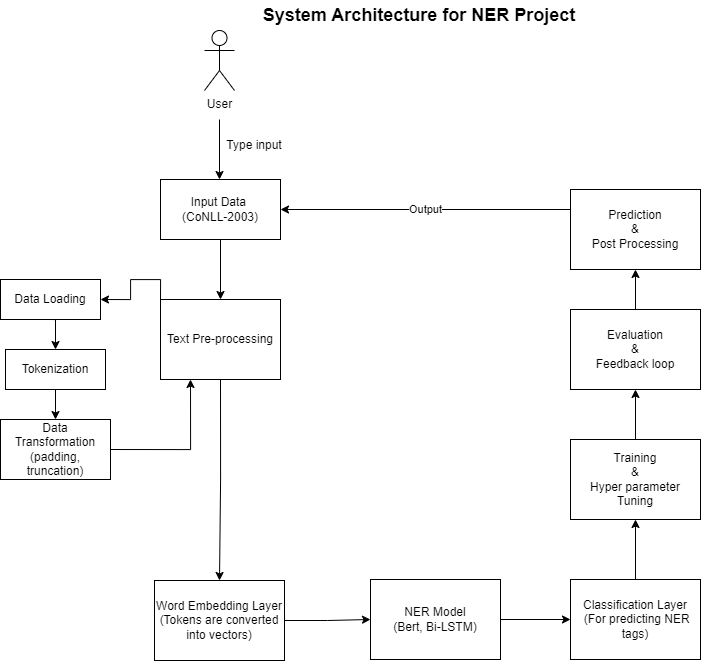

# Importing Necessary Libraries

In [191]:
!pip install transformers 
# This command installs the 'transformers' library from Hugging Face, which provides a collection of pre-trained models and utilities for Natural Language Processing (NLP) tasks

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [192]:
import torch
# PyTorch, a library for tensor operations and building neural networks.

from transformers import BertTokenizerFast, BertForTokenClassification
# Provides BERT tokenizer and token classification model for NER tasks.

from torch.utils.data import DataLoader
# Tool for batching and iterating over a dataset efficiently.

from transformers import AdamW
# Adam optimizer with weight decay, for training deep learning models.

from tqdm import tqdm
# Adds progress bars to loops for monitoring training progress.


# Dataset

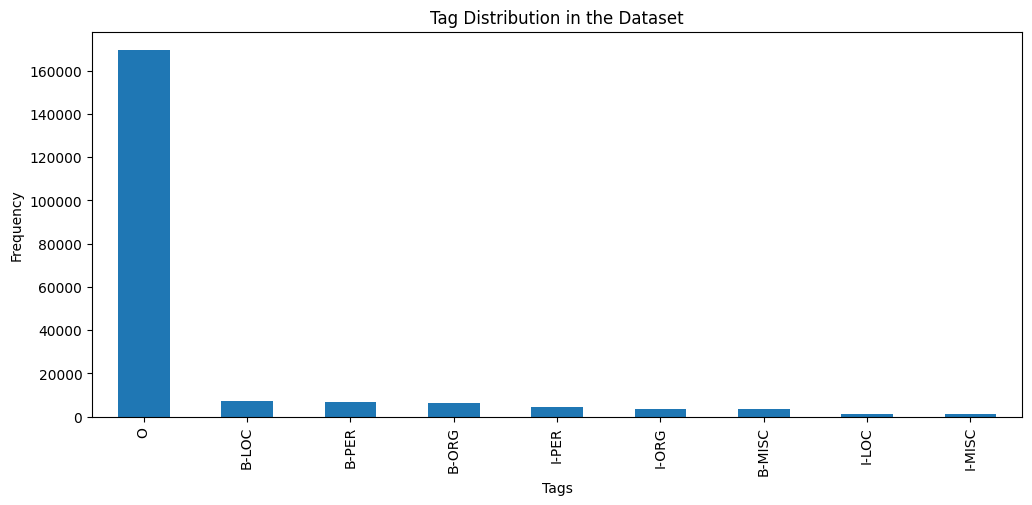

Number of training sentences: 946
Number of unique words in training set: 23623
Number of unique tags in training set: 9


In [226]:
import pandas as pd
import matplotlib.pyplot as plt

def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file if line.strip()]
    sentences, words, tags = [], [], []
    for line in lines:
        if line.startswith("-DOCSTART-"):
            sentences.append([])
        else:
            word_info = line.split()
            if len(word_info) == 4:
                word, pos, chunk, tag = word_info
                words.append(word)
                tags.append(tag)
                sentences[-1].append((word, tag))
    return sentences, words, tags

def visualize_data_distribution(tags):
    tag_counts = pd.Series(tags).value_counts()
    plt.figure(figsize=(12,5))
    tag_counts.plot(kind='bar')
    plt.title('Tag Distribution in the Dataset')
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Paths to the data files
train_path = '../input/conll003-englishversion/train.txt'
valid_path = '../input/conll003-englishversion/valid.txt'
test_path = '../input/conll003-englishversion/test.txt'

# Loading the datasets
train_sentences, train_words, train_tags = load_dataset(train_path)
valid_sentences, valid_words, valid_tags = load_dataset(valid_path)
test_sentences, test_words, test_tags = load_dataset(test_path)

# Visualizing the tag distribution in the training set
visualize_data_distribution(train_tags)

# Printing out some basic dataset information
print(f'Number of training sentences: {len(train_sentences)}')
print(f'Number of unique words in training set: {len(set(train_words))}')
print(f'Number of unique tags in training set: {len(set(train_tags))}')


 # Define Dataset Loading and Visualization Functions

In [227]:
def read_labels(file_path):
    labels = set()
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # The NER tag is the last element on the line
            if len(parts) > 1:  # This checks that it's not an empty line
                labels.add(parts[-1])  # Add the NER tag to the set
    return labels

# Read labels from the dataset
train_labels = read_labels('/kaggle/input/conll003-englishversion/train.txt')
valid_labels = read_labels('/kaggle/input/conll003-englishversion/valid.txt')
test_labels = read_labels('/kaggle/input/conll003-englishversion/test.txt')

# Combine all labels to get the unique ones
all_labels = set(list(train_labels) + list(valid_labels) + list(test_labels))
num_labels = len(all_labels)  # This should now give you the correct number of unique labels

print(f'Number of unique labels: {num_labels}')
print('All the Labels : ',all_labels)

Number of unique labels: 9
All the Labels :  {'I-MISC', 'I-ORG', 'I-LOC', 'B-ORG', 'I-PER', 'B-MISC', 'B-PER', 'O', 'B-LOC'}


**Label Interpretation**:

The **BIO**`(Begin-Inside-Outside)` tagging scheme is utilized in Named Entity Recognition to denote the position of tokens within named entities in text. Each token is prefixed with a label that identifies its role in an entity:

- `B-` (Begin): Signifies the beginning of a named entity.
- `I-` (Inside): Denotes that the token is part of an entity already initiated by a `B-` prefix.
- `O` (Outside): Indicates that the token is not part of a named entity.

Specific entity types are tagged as follows:
- `ORG` for Organizations: Identifies corporations, agencies, and other groups.
- `PER` for Persons: Marks individual names.
- `LOC` for Locations: Pinpoints geographical entities.
- `MISC` for Miscellaneous: Catches entities that don't fall under the other categories.

The Unique Labels in my dataset are:
1. - `O`: Non-entity, used for tokens that are not part of a named entity.
2. - `B-LOC`: Beginning of a location name.
3. - `I-LOC`: Token inside a location name.
4. - `B-MISC`: Beginning of a miscellaneous entity that does not belong to the pre-defined categories of locations, organizations, or person names.
5. - `I-MISC`: Token inside a miscellaneous entity.
6. - `B-ORG`: Beginning of an organization name.
7. - `I-ORG`: Token inside an organization name.
8. - `B-PER`: Beginning of a person's name.
9. - `I-PER`: Token inside a person's name.


**Interpretation**: 

* This bar chart illustrates the label distribution in the NER training data, revealing a **predominance of 'O' (non-entity) labels.** 
* Such imbalance require using **precision**, **recall**, and **F1-score** metrics for model evaluation, ensuring that the used BERT and BiLSTM models are accurately identifying all entity types, **not just the most frequent ones.**

### Model Setup and Device Configuration

The next cell sets up the BERT model for token classification, which will be used for the Named Entity Recognition (NER) task:

- `device`: Determines if a CUDA-compatible GPU is available for training (preferred for performance), otherwise defaults to using the CPU.
- `tokenizer`: Loads the `BertTokenizerFast`, which is optimized for speed, from the pre-trained 'bert-base-uncased' model. This tokenizer will convert text input into tokens that the BERT model can understand.
- `model`: Initializes the `BertForTokenClassification` with the pre-trained 'bert-base-uncased' weights and configures it for the number of NER labels in our dataset.
- `model.to(device)`: Moves the model to the GPU if available, allowing for faster computation.


# Setup Device and Tokenizer

In [228]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# Define the Custom Dataset Class

In [232]:
from torch.utils.data import Dataset
import torch

class NERDataset(Dataset):
    def __init__(self, tokenizer, file_path, tag_map):
        self.tokenizer = tokenizer
        self.sentences = []
        self.labels = []

        with open(file_path, 'r') as f:
            sentence = []
            label = []
            for line in f:
                line = line.strip()
                if line == "":  # New sentence
                    if sentence:
                        self.sentences.append(sentence)
                        self.labels.append(label)
                        sentence = []
                        label = []
                else:
                    parts = line.split()
                    if len(parts) > 2:  # This handles cases where the token itself contains spaces
                        token = " ".join(parts[:-1])  # Join all but the last part
                        tag = parts[-1]  # The last part is the tag
                    else:
                        token, tag = parts
                    sentence.append(token)
                    label.append(tag_map[tag])
            # Catch the last sentence if the file doesn't end with a newline
            if sentence:
                self.sentences.append(sentence)
                self.labels.append(label)
        self.tag_map = tag_map

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Create a new labels tensor with -100 (ignore index) for padding
        label_tensor = torch.full((128,), fill_value=-100, dtype=torch.long)

        # Set labels for the `max_length` first tokens, including the [CLS] token
        label_tensor[1:len(label) + 1] = torch.LongTensor(label)

        # Add the [SEP] token at the end
        label_tensor[len(label) + 1] = self.tag_map["O"]

        encoding['labels'] = label_tensor
        
        return {key: tensor.squeeze(0) for key, tensor in encoding.items()}


In [233]:
# Create a dictionary mapping each label in all_labels to a unique integer.
# all_labels is sorted, and each label is paired with an index using enumerate.
tag_map = {tag: idx for idx, tag in enumerate(sorted(all_labels))}


In [234]:
# Create datasets
train_dataset = NERDataset(tokenizer, '/kaggle/input/conll003-englishversion/train.txt', tag_map)
valid_dataset = NERDataset(tokenizer, '/kaggle/input/conll003-englishversion/valid.txt', tag_map)
test_dataset = NERDataset(tokenizer, '/kaggle/input/conll003-englishversion/test.txt', tag_map)


In [235]:
# Print tag_map to ensure all tags have an assigned index
print("Tag Map:", tag_map)


Tag Map: {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}


In [210]:
# Display tokenization and label shape for a sample
sample_sentence = train_dataset.sentences[0]
sample_label = train_dataset.labels[0]  # Use the labels corresponding to the first sentence

# Convert all integer labels in sample_label to their string representations using the reverse of tag_map
int_to_str_tag_map = {idx: tag for tag, idx in tag_map.items()}
sample_label = [int_to_str_tag_map[tag] if isinstance(tag, int) else tag for tag in sample_label]

print("Original Sentence:", sample_sentence)
print("Original Labels:", sample_label)

sample_encoding = tokenizer(
    sample_sentence,
    is_split_into_words=True,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Ensure all elements in sample_label are strings
assert all(isinstance(tag, str) for tag in sample_label), "Labels should be strings."

# Create the label tensor using string tags
sample_label_tensor = torch.full((128,), fill_value=-100, dtype=torch.long)
sample_label_tensor[1:len(sample_label) + 1] = torch.LongTensor(
    [tag_map[tag] for tag in sample_label]
)

print("Tokenized Input IDs:", sample_encoding['input_ids'])
print("Input IDs Shape:", sample_encoding['input_ids'].shape)
print("Label Tensor:", sample_label_tensor)
print("Label Tensor Shape:", sample_label_tensor.shape)


Original Sentence: ['EU NNP B-NP', 'rejects VBZ B-VP', 'German JJ B-NP', 'call NN I-NP', 'to TO B-VP', 'boycott VB I-VP', 'British JJ B-NP', 'lamb NN I-NP', '. . O']
Original Labels: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
Tokenized Input IDs: tensor([[  101,  7327,  1050, 16275,  1038,  1011, 27937, 19164,  1058,  2497,
          2480,  1038,  1011, 21210,  2446, 29017,  1038,  1011, 27937,  2655,
          1050,  2078,  1045,  1011, 27937,  2000,  2000,  1038,  1011, 21210,
         17757,  1058,  2497,  1045,  1011, 21210,  2329, 29017,  1038,  1011,
         27937, 12559,  1050,  2078,  1045,  1011, 27937,  1012,  1012,  1051,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,   

In [236]:
# Assuming train_dataset, valid_dataset, test_dataset are the full datasets

# Create the DataLoaders for iterating over the full datasets
# DataLoader for the full training dataset, with a batch size of 8 samples and shuffling enabled to randomize the order of samples.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# DataLoader for the full validation dataset, with a batch size of 8 samples, no shuffling is typically needed for validation.
valid_loader = DataLoader(valid_dataset, batch_size=8)

# DataLoader for the full testing dataset, with a batch size of 8 samples, no shuffling is typically needed for testing.
test_loader = DataLoader(test_dataset, batch_size=8)


In [237]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [238]:
print(f"Total number of training batches: {len(train_loader)}")
print(f"Total number of validation batches: {len(valid_loader)}")
print(f"Total number of testing batches: {len(test_loader)}")


Total number of training batches: 1874
Total number of validation batches: 434
Total number of testing batches: 461


# Training Loop

In [239]:
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

epochs = 3
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Define the function to calculate the evaluation metrics
def calculate_metrics(preds, labels):
    preds_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    # Only calculate metrics for non-ignored labels
    valid_indices = labels_flat != -100
    preds_flat = preds_flat[valid_indices]
    labels_flat = labels_flat[valid_indices]
    accuracy = accuracy_score(labels_flat, preds_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='macro')
    return accuracy, precision, recall, f1

# Training and validation loop
for epoch in range(epochs):
    # Training step
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        model.zero_grad()
        outputs = model(**batch)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.2f}")

    # Validation step
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = batch['labels'].cpu().numpy()

        predictions.extend(logits)
        true_labels.extend(label_ids)

    avg_val_loss = val_loss / len(valid_loader)
    accuracy, precision, recall, f1 = calculate_metrics(np.array(predictions), np.array(true_labels))

    print(f"Validation loss: {avg_val_loss:.2f}")
    print(f"Validation Accuracy: {accuracy:.2f}")
    print(f"Validation Precision: {precision:.2f}")
    print(f"Validation Recall: {recall:.2f}")
    print(f"Validation F1-Score: {f1:.2f}")


Training Epoch 0: 100%|██████████| 1874/1874 [03:32<00:00,  8.81it/s]


Average training loss: 0.41


Validation Epoch 0: 100%|██████████| 434/434 [00:16<00:00, 26.18it/s]


Validation loss: 0.28
Validation Accuracy: 0.91
Validation Precision: 0.80
Validation Recall: 0.48
Validation F1-Score: 0.59


Training Epoch 1: 100%|██████████| 1874/1874 [03:32<00:00,  8.81it/s]


Average training loss: 0.21


Validation Epoch 1: 100%|██████████| 434/434 [00:16<00:00, 26.19it/s]


Validation loss: 0.19
Validation Accuracy: 0.93
Validation Precision: 0.79
Validation Recall: 0.68
Validation F1-Score: 0.73


Training Epoch 2: 100%|██████████| 1874/1874 [03:32<00:00,  8.81it/s]


Average training loss: 0.15


Validation Epoch 2: 100%|██████████| 434/434 [00:16<00:00, 26.13it/s]


Validation loss: 0.17
Validation Accuracy: 0.95
Validation Precision: 0.83
Validation Recall: 0.73
Validation F1-Score: 0.77


# Saving our BERT Model

In [240]:
model.save_pretrained('/kaggle/working/my_bert_model')

# Model Evaluation & Performance

In [241]:
# Test the model to evaluate its performance
model.eval()  # put model in evaluation mode
test_loss, test_accuracy, test_precision, test_recall, test_f1 = 0, 0, 0, 0, 0

# No need to track gradients for validation
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        # Transfer to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Compute loss
        loss = outputs.loss
        test_loss += loss.item()

        # Get the predictions
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = batch['labels'].cpu().numpy()

        # Calculate the evaluation metrics
        batch_accuracy, batch_precision, batch_recall, batch_f1 = calculate_metrics(logits, label_ids)
        test_accuracy += batch_accuracy
        test_precision += batch_precision
        test_recall += batch_recall
        test_f1 += batch_f1

# Compute the average loss and average metrics
avg_test_loss = test_loss / len(test_loader)
avg_test_accuracy = test_accuracy / len(test_loader)
avg_test_precision = test_precision / len(test_loader)
avg_test_recall = test_recall / len(test_loader)
avg_test_f1 = test_f1 / len(test_loader)

print(f"Test loss: {avg_test_loss:.2f}")
print(f"Test Accuracy: {avg_test_accuracy:.2f}")
print(f"Test Precision: {avg_test_precision:.2f}")
print(f"Test Recall: {avg_test_recall:.2f}")
print(f"Test F1-Score: {avg_test_f1:.2f}")


Testing:   0%|          | 0/461 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Testing:   3%|▎         | 12/461 [00:00<00:18, 23.90it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Test loss: 0.22
Test Accuracy: 0.95
Test Precision: 0.77
Test Recall: 0.74
Test F1-Score: 0.74


In [173]:
!pip install torchcrf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [243]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm

# Define and Instantiate the BiLSTM Model

In [244]:
#BiLSTMForTokenClassification Model Definition
class BiLSTMForTokenClassification(nn.Module):
    def __init__(self, num_labels, hidden_size=128, num_layers=2, dropout=0.1):
        super(BiLSTMForTokenClassification, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_size, num_labels)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        embeddings = self.dropout(embeddings)
        lstm_output, _ = self.bilstm(embeddings)
        logits = self.fc(lstm_output)
        return logits


In [245]:
#Model Instantiation and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bilstm_model = BiLSTMForTokenClassification(num_labels=num_labels)
bilstm_model.to(device)
bilstm_optimizer = optim.AdamW(bilstm_model.parameters(), lr=5e-5)
bilstm_scheduler = torch.optim.lr_scheduler.StepLR(bilstm_optimizer, step_size=10, gamma=0.5)


# BiLSTM Training Loop

In [246]:
# Training Loop
epochs = 3
bilstm_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        bilstm_optimizer.zero_grad()
        logits = bilstm_model(input_ids)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
        total_loss += loss.item()

        loss.backward()
        bilstm_optimizer.step()
        bilstm_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.2f}")


Training Epoch 0: 100%|██████████| 1874/1874 [00:20<00:00, 93.43it/s]


Average training loss: 2.12


Training Epoch 1: 100%|██████████| 1874/1874 [00:19<00:00, 93.82it/s]


Average training loss: 2.12


Training Epoch 2: 100%|██████████| 1874/1874 [00:19<00:00, 93.97it/s]

Average training loss: 2.12


# BiLSTM Evaluation Loop

In [181]:
#BiLSTM Evaluation Loop
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate metrics for all batches
def compute_metrics(predictions, true_labels):
    # Flatten all the predictions and true values
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    
    # Only evaluate on non-ignored indices (-100 is used for ignored)
    valid_indices = true_labels != -100
    predictions = predictions[valid_indices]
    true_labels = true_labels[valid_indices]
    
    f1 = f1_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)
    
    return f1, accuracy

# Place the model in evaluation mode
bilstm_model.eval()

# Initialize lists to gather full prediction and label sets
all_predictions, all_labels = [], []

# Evaluate data for one epoch
for batch in tqdm(valid_loader, desc="Evaluating"):
    # Add batch to device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Telling the model not to compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = bilstm_model(batch['input_ids'])

    # Move logits and labels to CPU
    logits = outputs.detach().cpu().numpy()
    label_ids = batch['labels'].to('cpu').numpy()

    # Store predictions and true labels
    all_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    all_labels.extend([list(l) for l in label_ids])

# Calculate metrics
f1, accuracy = compute_metrics(all_predictions, all_labels)

print(f"Validation F1-Score: {f1:.2f}")
print(f"Validation Accuracy: {accuracy:.2f}")


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 114.43it/s]

torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
Validation F1-Score: 0.11
Validation Accuracy: 0.79


# Save BiLSTM Model

In [247]:
# Save the entire model
torch.save(bilstm_model, '/kaggle/working/my_bilstm_model.pth')

print('Model saved to /kaggle/working/my_bilstm_model.pth')


Model saved to /kaggle/working/my_bilstm_model.pth


# Model Summaries

In [248]:
from torchinfo import summary

# Assuming your model variable holds the BertForTokenClassification model
# and that you have a batch of data available in input_ids
# We will create a batch of dummy data with two input sequences for the purpose of model summary
input_ids = tokenizer(['Hello, this is a test.', 'Here is another sentence.'], 
                      padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids

# Move the tensor to the appropriate device
input_ids = input_ids.to(device)

# Use torchinfo to print the summary
bert_model_summary = summary(model, input_data=(input_ids,), verbose=0)  # You can set verbose to 1 for more detail
print(bert_model_summary)


Layer (type:depth-idx)                                  Output Shape              Param #
BertForTokenClassification                              [2, 9, 9]                 --
├─BertModel: 1-1                                        [2, 9, 768]               --
│    └─BertEmbeddings: 2-1                              [2, 9, 768]               --
│    │    └─Embedding: 3-1                              [2, 9, 768]               23,440,896
│    │    └─Embedding: 3-2                              [2, 9, 768]               1,536
│    │    └─Embedding: 3-3                              [1, 9, 768]               393,216
│    │    └─LayerNorm: 3-4                              [2, 9, 768]               1,536
│    │    └─Dropout: 3-5                                [2, 9, 768]               --
│    └─BertEncoder: 2-2                                 [2, 9, 768]               --
│    │    └─ModuleList: 3-6                             --                        85,054,464
├─Dropout: 1-2                   

In [249]:
import torch
from torchinfo import summary

# Load the BiLSTM model
bilstm_model = torch.load('/kaggle/working/my_bilstm_model.pth')

# Assuming the BiLSTM expects the same input_ids as the BERT model
# Generate BiLSTM model summary
bilstm_model_summary = summary(bilstm_model, input_data=(input_ids.to(device),), verbose=0)
print(bilstm_model_summary)


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMForTokenClassification             [2, 9, 9]                 --
├─Embedding: 1-1                         [2, 9, 128]               3,906,816
├─Dropout: 1-2                           [2, 9, 128]               --
├─LSTM: 1-3                              [2, 9, 256]               659,456
├─Linear: 1-4                            [2, 9, 9]                 2,313
Total params: 4,568,585
Trainable params: 4,568,585
Non-trainable params: 0
Total mult-adds (M): 19.69
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 18.27
Estimated Total Size (MB): 18.33


# Models Prediction

In [252]:
# Load the trained BERT-based model (if not already loaded)
from transformers import BertForTokenClassification

bert_model = BertForTokenClassification.from_pretrained('/kaggle/working/my_bert_model')

# Load the trained BiLSTM-based model (if not already loaded)
# Assuming you have previously saved it using torch.save
import torch

bilstm_model = torch.load('/kaggle/working/my_bilstm_model.pth')


In [270]:
import torch
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
import numpy as np

# Example input text
input_text = "Ahmed lives in New York City in US"

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Define a function to make predictions using the BERT-based model
def predict_with_bert_model(model, text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted labels
    predicted_labels = np.argmax(outputs.logits, axis=2).tolist()[0]
    
    return predicted_labels



# Make predictions using the BERT-based model
bert_predictions = predict_with_bert_model(bert_model, input_text)

print("BERT Predictions:", bert_predictions)


Ahmed lives in New York City in US
BERT Predictions: [8, 3, 8, 0, 0, 8, 8, 8, 8, 3]


In [271]:
import torch

def predict_with_bilstm_model(model, text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Move the inputs to the appropriate device
    input_ids = inputs['input_ids'].to(model.embedding.weight.device)  # Use the device of the embedding layer

    # Forward pass through the model
    with torch.no_grad():
        logits = model(input_ids)

    # Get the predicted labels
    predicted_labels = torch.argmax(logits, dim=2).squeeze().tolist()
    return predicted_labels

# Example usage:
input_text = "Ahmed lives in New York City in US"
bilstm_predictions = predict_with_bilstm_model(bilstm_model, input_text)
print(input_text)

print("BiLSTM Predictions:", bilstm_predictions)


Ahmed lives in New York City in US
BiLSTM Predictions: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [273]:
def predict_bert(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Move tensors to the appropriate device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Put the model in evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits and apply softmax to get probabilities
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(probabilities, dim=-1)

    return predictions[0].cpu().numpy()


In [274]:
def predict_bilstm(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Extract input_ids and move to the appropriate device
    input_ids = inputs['input_ids'].to(device)

    # Put the model in evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        logits = model(input_ids)

    # Apply softmax to get probabilities and then get predictions
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(probabilities, dim=-1)

    return predictions[0].cpu().numpy()


In [275]:
sentence = "Ahmed lives in New York City in US."
bert_predictions = predict_bert(model, tokenizer, sentence)
bilstm_predictions = predict_bilstm(bilstm_model, tokenizer, sentence)

# Convert predictions to tag names
bert_tags = [int_to_str_tag_map[p] for p in bert_predictions]
bilstm_tags = [int_to_str_tag_map[p] for p in bilstm_predictions]

print("BERT Predictions:", bert_tags)
print("BiLSTM Predictions:", bilstm_tags)


BERT Predictions: ['O', 'B-PER', 'O', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PER']
BiLSTM Predictions: ['I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC']


## Prediction Results Summary

### BERT Model
- **Non-Entities**: Tokens marked as `'O'` signify non-entities.
- **Persons**: `'B-PER'` tags indicate the start of a person's name.
- **Locations**: `'B-LOC'` tags denote the beginning of a location name.

### BiLSTM Model
- **Inside Locations**: `'I-LOC'` tags represent tokens within a location name.
- **Start of Locations**: `'B-LOC'` tags mark the start of a location name.

### Insights
- **BERT**: Shows a balance in identifying persons and locations.
- **BiLSTM**: More focused on identifying location entities.
- **Observation**: The variation in predictions between the models underscores their different learning patterns and sensitivities.


## Interpretation of Model Predictions

You may notice that there are differences in the predictions made by the BiLSTM and BERT models for the same input sentence. This is expected and can be attributed to several factors related to the models' architectures, training data, and tokenization process:

1. **Model Architecture**: The BiLSTM and BERT models have different architectures. BiLSTM is a recurrent neural network (RNN), while BERT is a transformer-based model. These architectural differences can lead to variations in predictions.

2. **Pre-trained Word Embeddings**: BERT uses pre-trained word embeddings that capture rich contextual information from a large corpus of text. In contrast, the BiLSTM model might use different embeddings or rely more on the training data provided, resulting in different understandings of word meanings in context.

3. **Training Data**: The two models may have been trained on different datasets. The quality, quantity, and diversity of the training data can impact a model's performance and its ability to make predictions.

4. **Fine-tuning**: If you fine-tuned the BERT model on a specific task or dataset, it might have learned task-specific patterns that the BiLSTM model doesn't possess.

5. **Tokenization**: Both models use tokenization, but the tokenizers might tokenize the input sentence differently, affecting the input representations and predictions.

6. **Inference Differences**: The way you perform inference and post-processing for each model can also lead to differences in the final predictions.

In conclusion, it's normal for different models to produce slightly different results due to their unique characteristics and training. The choice of which model to use should be based on the specific task and requirements.
